# M2177.003100 Deep Learning <br> Assignment #4 Implementing Conditional Generative Adversarial Nets - part2 Labeld Face Data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jaeyoon Yoo, November 2017

In this notebook, you will learn how to implement conditional Genverative Adversarial Nets (cGANs) <br>
The goal here is to build GANs that draw a face given its label. You can draw a black male/black female/white male/white female as you gives an input at the end of training. <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #2:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- [4] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
- [5] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

## 0. Download and load MNIST datasets
Unzip the face_dataset.tar.gz and locate them into your data directory. Following is how to load the data. Modify  *data_dir* to be the directory the data is in. Or you will get an error.<br>

In [1]:
from utils import load_face
data_dir = './data/face_dataset'
im, label = load_face(data_dir)

There are 13143 images and corresponding lables. Labels have three values. Following is the detail:

Label1 - Male/Female : positive value means male<br>
Label2 - White/Not white : positive value means White<br>
Lable3 - Black/Not black : positive value menas black<br>
The large value represents the more property it has.

Note that the labels are not normalized and check the data by runing and modifying following code

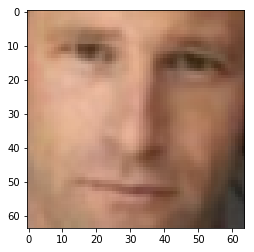

[ 1.56834639  1.73720325 -0.92972867]


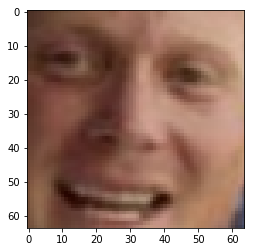

[ 0.16985062  0.42270934 -1.28218444]


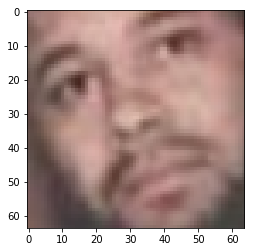

[ 0.99774898 -0.15737693 -0.75644725]


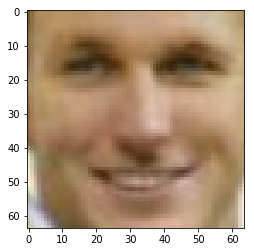

[ 1.12271853  1.91614437 -2.51421429]


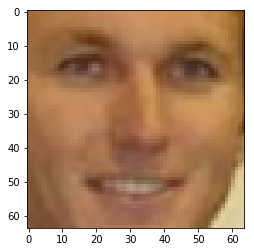

[ 1.07821424  1.67621104 -2.27805594]


In [2]:
import pylab as plt
for i in range(5):
    plt.imshow(im[i])
    plt.show()
    print(label[i])

## <a name="1"></a> 1. Building a network

In this section, you will implement neural networks for (1) generative model (2) discriminative model. You can reuse your code in part1 and improve it. Just write the code in whatever way you find most clear.

In [3]:
from utils import load_face
from utils import getNext_batch
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import sample_label_face
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

learning_rate = 0.0002
batch_size = 128
EPOCH = 300
display_step = 50
sample_size = 100
y_dim = 3
channel = 3


It is time for a generative model. You can change anything including the argument If you need. Feel free to change it and improve it.

In [4]:
def gern_net(batch_size, z , y ,sample_size, y_dim, output_size):
    #### TODO ####
    with tf.variable_scope('gen'):
        z = tf.concat([z, y], 1)
        initializer = tf.random_normal_initializer(stddev=0.01) #tf.contrib.layers.xavier_initializer()
        
        w1 = tf.get_variable('w1', [z.shape[1], 1024], tf.float32, initializer = initializer)
        b1 = tf.get_variable('b1', [1024], initializer = tf.constant_initializer(0.0))
        net = tf.nn.relu(batch_normal(fully_connect(z, w1, b1), scope='gern_bn1'))
        
        w2 = tf.get_variable('w2', [net.shape[1], 128*16*16], tf.float32, initializer = initializer)
        b2 = tf.get_variable('b2', [128*16*16], initializer = tf.constant_initializer(0.0))
        net = tf.nn.relu(batch_normal(fully_connect(net, w2, b2), scope='gern_bn2'))
        net = tf.reshape(net, [batch_size, 16, 16, 128])
        
        w3 = tf.get_variable('w3', [5, 5, 64, net.shape[-1]], initializer=initializer)
        b3 = tf.get_variable('b3', [64], initializer=tf.constant_initializer(0.0))
        net = de_conv(net, w3, b3, out_shape=[batch_size, 32, 32, 64])
        net = tf.nn.relu(batch_normal(net, scope='gern_bn3'))
        
        w4 = tf.get_variable('w4', [5, 5, 3, net.shape[-1]], initializer=initializer)
        b4 = tf.get_variable('b4', [3], initializer=tf.constant_initializer(0.0))
        net = de_conv(net, w4, b4, out_shape=[batch_size, 64, 64, 3])
        
        return tf.nn.sigmoid(net)

Now, it's time for a discriminative model. Again, you can change anything if you need

In [5]:
def dis_net(data_array , y, reuse=False):
    #### TODO ####
    with tf.variable_scope('dis', reuse=reuse):
        #### TODO ####
        #x = tf.reshape(image_data, [128, 28*28])
        #image_y = tf.concat([x, y], 1)
        #image_y = image_y + tf.random_normal(shape=tf.shape(image_y), mean=0.0, stddev=0.2, dtype=tf.float32)
        
        _, y_dim = y.get_shape()
        batch_size = data_array.shape[0]
        initializer = tf.random_normal_initializer(stddev=0.01) #tf.contrib.layers.xavier_initializer()
        
        y = tf.reshape(y, [batch_size, 1, 1, y_dim])
        x = conv_cond_concat(data_array, y)
        x = x + tf.random_normal(shape=tf.shape(x), mean=0.0, stddev=0.01, dtype=tf.float32)
        
        w1 = tf.get_variable('w1', [5, 5, x.shape[-1], 64], initializer=initializer)
        b1 = tf.get_variable('b1', [64], initializer=tf.constant_initializer(0.0))
        net = lrelu(conv2d(x, w1, b1))
        
        w2 = tf.get_variable('w2', [5, 5, net.shape[-1], 128], initializer=initializer)
        b2 = tf.get_variable('b2', [128], initializer=tf.constant_initializer(0.0))
        net = lrelu(batch_normal(conv2d(net, w2, b2), scope='dis_bn1'))
        net = tf.reshape(net, [batch_size, -1])
        
        w3 = tf.get_variable('w3', [net.shape[1], 1024], tf.float32, initializer = initializer)
        b3 = tf.get_variable('b3', [1024], initializer = tf.constant_initializer(0.0))
        net = lrelu(batch_normal(fully_connect(net, w3, b3), 'dis_bn2'))
        
        w4 = tf.get_variable('w4', [net.shape[1], 1], tf.float32, initializer = initializer)
        b4 = tf.get_variable('b4', [1], initializer = tf.constant_initializer(0.0))
        out_logit = fully_connect(net, w4, b4)
        out = tf.nn.sigmoid(out_logit)
        
        return out, out_logit

## <a name="2"></a> 2. Build a main part and train

In this section, you will implement the main part. Then run the code and check the model draws the face properly.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test' directory that resulting image will be saved in. You can change the directory as you want.

In [6]:
from utils import load_mnist
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

g_learning_rate = 0.0001 #2
d_learning_rate = 0.0001 #2
batch_size = 256
EPOCH = 500
display_step = 100
sample_size = 100
y_dim = 3
channel = 3
output_size = 64
sample_dir = 'samples_for_test'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Feel free to fill in the main part. You can copy the part1 code or write your own code.

Your goal is to **generate 4 row and 8 column images(32 total)**.

**Each row should correspond to each label**.

First row : black male<br>
Second row: black female<br>
Third row : white male<br>
Fourth row: white female<br>

You can use "save_images" method in *utils.py* to align generated image by 4*8. See part1 code to get how to use it.

You must show **at least three generated images**. (At the beginning of ,in the midway of, at the end of training.)


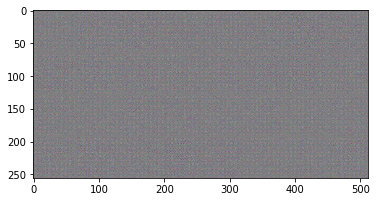

EPOCH 0 step 50: D: loss = 1.3503881 G: loss=0.7227685 
EPOCH 1 step 100: D: loss = 1.3617921 G: loss=0.6939637 
EPOCH 2 step 150: D: loss = 1.3681402 G: loss=0.7061916 
EPOCH 3 step 200: D: loss = 1.3729097 G: loss=0.6819161 
EPOCH 4 step 250: D: loss = 1.3645222 G: loss=0.7040176 
EPOCH 5 step 300: D: loss = 1.3814408 G: loss=0.6922147 
EPOCH 6 step 350: D: loss = 1.3701502 G: loss=0.7110947 
EPOCH 7 step 400: D: loss = 1.3519113 G: loss=0.7215077 
EPOCH 8 step 450: D: loss = 1.3760883 G: loss=0.6870949 
EPOCH 9 step 500: D: loss = 1.3708019 G: loss=0.7137730 
EPOCH 10 step 550: D: loss = 1.3689731 G: loss=0.6960890 
EPOCH 11 step 600: D: loss = 1.3723810 G: loss=0.6963541 
EPOCH 12 step 650: D: loss = 1.3596791 G: loss=0.6963638 
EPOCH 13 step 700: D: loss = 1.3627497 G: loss=0.7013401 
EPOCH 14 step 750: D: loss = 1.3665195 G: loss=0.6864179 
EPOCH 15 step 800: D: loss = 1.3584887 G: loss=0.7018648 
EPOCH 16 step 850: D: loss = 1.3471482 G: loss=0.7076808 
EPOCH 17 step 900: D: los

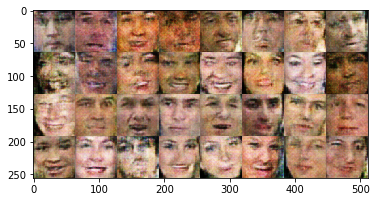

EPOCH 51 step 2650: D: loss = 1.3827525 G: loss=0.6960099 
EPOCH 52 step 2700: D: loss = 1.3863571 G: loss=0.6975738 
EPOCH 53 step 2750: D: loss = 1.3860066 G: loss=0.6931690 
EPOCH 54 step 2800: D: loss = 1.3839867 G: loss=0.6941329 
EPOCH 55 step 2850: D: loss = 1.3855467 G: loss=0.6947632 


In [ ]:
#### TODO ####
import sys
from PIL import Image

sample_z = np.random.uniform(-1 , 1 , size = [batch_size, sample_size])

y = tf.placeholder(tf.float32, [None , y_dim])

images = tf.placeholder(tf.float32, [batch_size, output_size, output_size, channel])

z = tf.placeholder(tf.float32, [None , sample_size])

fake_images = gern_net(batch_size, z , y ,sample_size, y_dim, output_size)

##the loss of gerenate network
D_pro, D_logits = dis_net(images, y, False)
G_pro, G_logits = dis_net(fake_images, y, True)

#### TODO ####
# DEFINE LOSS FUNCTION #

D_fake_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(G_pro), logits=G_logits))

D_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_pro), logits=D_logits))
G_fake_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(G_pro), logits=G_logits))

D_loss = D_real_loss + D_fake_loss
G_loss = G_fake_loss

#############

t_vars = tf.trainable_variables()

d_var = [var for var in t_vars if 'dis' in var.name]
g_var = [var for var in t_vars if 'gen' in var.name]

opti_D = tf.train.AdamOptimizer(learning_rate=g_learning_rate , beta1=0.5).minimize(D_loss , var_list=d_var)
opti_G = tf.train.AdamOptimizer(learning_rate=d_learning_rate , beta1=0.5).minimize(G_loss , var_list=g_var)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:

    sess.run(init)
    e = 0
    step = 0
    loss_step = 50
    Row = 4
    Column = 8
    
    while e <= EPOCH:
        batch_num = 0
        while batch_num < len(im) / batch_size - 1:

            step = step + 1

            realbatch_array , real_labels = getNext_batch(im, label, batch_num, batch_size)
            
            #Get the z
            batch_z = np.random.uniform(-1 , 1 , size=[batch_size , sample_size])

            _ = sess.run(opti_D, feed_dict={images:realbatch_array, z:batch_z , y:real_labels})
            _ = sess.run(opti_G, feed_dict={z: batch_z , y:real_labels})

            batch_num += 1

            if step % loss_step == 0:
                d_get_loss = sess.run(D_loss , feed_dict = {images:realbatch_array , z:batch_z , y:real_labels})
                g_get_loss = sess.run(G_loss , feed_dict = {z: batch_z , y:real_labels})
                print("EPOCH %d step %d: D: loss = %.7f G: loss=%.7f " % (e , step , d_get_loss , g_get_loss))

            if e % 50 == 0 and np.mod(step, display_step) == 1:
                sample_labels = sample_label_face(batch_size)
                sample_images = sess.run(fake_images , feed_dict={z:sample_z , y:sample_labels})
                
                sample = []
                wb_label = [2, 1]
                for k in range(Row // 2):
                    cnt_1 = 0
                    tmp_1 = []
                    cnt_2 = 0
                    tmp_2 = []
                    for i, img in enumerate(sample_images):
                        if sample_labels[i][wb_label[k]] > 0:
                            if cnt_1 < 8 and sample_labels[i][0] > 0:
                                tmp_1.append(img)
                                cnt_1 += 1
                            elif cnt_2 < 8 and sample_labels[i][0] <= 0:
                                tmp_2.append(img)
                                cnt_2 += 1
                            if cnt_1 == 8 and cnt_2 == 8:
                                break
                    tmp_1 = np.hstack((np.asarray(tmp_1))) * 255
                    tmp_2 = np.hstack((np.asarray(tmp_2))) * 255
                    sample.append(np.asarray(np.append(tmp_1, tmp_2, axis=0)))
                sample = np.vstack((np.asarray(sample)))
                sample_images = Image.fromarray(sample.astype('uint8'))
                
                image_name = './{}/face_train_{:02d}_{:04d}.png'.format(sample_dir , e , step)
                sample_images.save(image_name)
                
                plt.imshow(sample_images)
                plt.show()
                
        e = e + 1
        batch_num = 0